In [13]:
import os
from PIL import Image

import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset, FastRCNNLabeledDataset
from helper import collate_fn, draw_box

import pickle
import time
import copy

In [2]:
# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file

# image_folder = '../data'
# annotation_csv = '../data/annotation.csv'

image_folder = '/Users/nhungle/Downloads/dl20_data'
annotation_csv = '/Users/nhungle/Downloads/dl20_data/annotation.csv'

In [3]:
# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)

In [37]:
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

# Labeled dataset

In [14]:
def inspect_target(index):
    NUM_SAMPLE_PER_SCENE = 126
    NUM_IMAGE_PER_SAMPLE = 6
    image_names = [
        'CAM_FRONT_LEFT.jpeg',
        'CAM_FRONT.jpeg',
        'CAM_FRONT_RIGHT.jpeg',
        'CAM_BACK_LEFT.jpeg',
        'CAM_BACK.jpeg',
        'CAM_BACK_RIGHT.jpeg',
        ]
    scene_index = labeled_scene_index 
    scene_id = scene_index[index // NUM_SAMPLE_PER_SCENE]
    sample_id = index % NUM_SAMPLE_PER_SCENE
    sample_path = os.path.join(image_folder, f'scene_{scene_id}', f'sample_{sample_id}') 
    images = []
    for image_name in image_names:
        image_path = os.path.join(sample_path, image_name)
        image = Image.open(image_path)
        images.append(transform(image))
    image_tensor = torch.stack(images)
    annotation_file = annotation_csv 
    annotation_dataframe = pd.read_csv(annotation_file)
    data_entries = annotation_dataframe[(annotation_dataframe['scene'] == scene_id) & (annotation_dataframe['sample'] == sample_id)]
    corners = data_entries[['fl_x', 'fr_x', 'bl_x', 'br_x', 'fl_y', 'fr_y','bl_y', 'br_y']].to_numpy()
    categories = data_entries.category_id.to_numpy()
    num_objects = len(categories)
    boxes = []
    for i in range(num_objects):
        xmin = min(corners[i][:4])
        xmax = max(corners[i][:4])
        ymin = min(corners[i][4:])
        ymax = max(corners[i][4:])
        boxes.append([xmin, ymin, xmax, ymax])
    return data_entries, image_tensor

In [5]:
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
transform = torchvision.transforms.ToTensor()
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )
fasterRCNN_trainset = FastRCNNLabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )
trainloader = torch.utils.data.DataLoader(fasterRCNN_trainset,
                                          batch_size=1,
                                          shuffle=True,
                                          num_workers=2, collate_fn=collate_fn)

In [113]:
sample, target, road_image, extra = iter(trainloader).next()
print(torch.stack(sample).shape)
sample = torch.stack(sample)

torch.Size([1, 6, 3, 256, 306])


In [114]:
index = target[0]['image_id'].item()
data_entries, idx_tensor = inspect_target(index)
data_entries["category_id"].values == target[0]['labels'].data.numpy()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [115]:
feature_extractor = torchvision.models.resnet18(pretrained=False)
feature_extractor = nn.Sequential(*list(feature_extractor.children())[:-2])
#feature_extractor.to(device)
for param in feature_extractor.parameters():
    param.requires_grad = True

In [141]:
def concat_features(features, dim = 2):
    #dim 0 ==> stacking the images in the channel dimension
    #dim 1 ==> stacking the images in row dimension
    #dim 2 ==> stacking the images in column dimension
    tensor_tuples = torch.unbind(features, dim=0)
    concatenated_fm = torch.cat(tensor_tuples, dim=dim)
    return concatenated_fm 

## Change this to work for higher batch size while combining mutliple samples

In [142]:
def prepare_inputs(sample):
    """
    Input: samples is a cuda tensor with size [batch_size, 6, 3, 256, 306]
    Output: a cuda tensor with size [batch_size, 512, 16, 114]
    """
    batch_size = sample.shape[0]
    extracted_fm = []
    for i in range(len(sample)):
        features = feature_extractor(sample[i])
        print(features.shape)
        features = concat_features(features)
        print(features.shape)
        extracted_fm.append(features)
    return extracted_fm


In [143]:
inputs = prepare_inputs(sample)

torch.Size([6, 512, 8, 10])
torch.Size([512, 8, 60])


In [145]:
inputs[0].shape

torch.Size([512, 8, 60])

In [147]:
# for iter_, (sample, target, road_image, extra) in enumerate(trainloader):
#     print(len(sample), sample[0].shape)
#     print(len(target))

# #     inputs = torch.stack(data[0]).squeeze()
# #     labels = data[1][0]

#     inputs = inputs.type(torch.FloatTensor).to(device)
    
    
#     break

## Fast RCNN

In [148]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

In [149]:
def customize_VGG16():
    model = torchvision.models.vgg16(pretrained=True)
    
    features = list(model.features)[:30]
    classifier = model.classifier
    
    classifier = list(classifier)
    # delete the Linear layer
    del classifier[6]
    classifier = nn.Sequential(*classifier)

    #freeze top4 conv layer
    for layer in features[:10]:
        for p in layer.parameters():
            p.requires_grad = False
    features = nn.Sequential(*features)
        
    return features, classifier

In [153]:
backbone, box_head = customize_VGG16()

In [154]:
backbone.out_channels = 512
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                           aspect_ratios=((0.5, 1.0, 2.0),))
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

In [155]:
model = torchvision.models.detection.faster_rcnn.FasterRCNN(
            backbone, 
            rpn_anchor_generator = anchor_generator,
            box_roi_pool = roi_pooler,
            box_head = box_head,
            num_classes = 9)
#             box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(4096, num_classes=9))

In [159]:
# Inspect inputs and target before bringing into model
print(type(inputs))

<class 'list'>


In [162]:
targets = list(target)

In [164]:
output = model(inputs,targets)

RuntimeError: The size of tensor a (512) must match the size of tensor b (3) at non-singleton dimension 0

In [537]:
def dice_loss(true, preds, epsilon = 1e-4):
    sh1, sh2 = preds.size()
    true = true.view(1, -1)
    preds = preds.view(1, -1)
    prod = torch.sum(true*preds,dim = 1)
    sum_tnp = torch.sum(true + preds, dim = 1)
    num = torch.sum(prod)
    denom = torch.sum(sum_tnp) + epsilon
    loss = 1 - 2*(num/denom)

    return torch.mean(loss)

In [538]:
def compute_dice(true, preds, epsilon = 1e-7):
    sh1, sh2 = preds.size()
    true = true.view(1, -1)
    preds = preds.view(1, -1)
    
    prod = torch.sum(true*preds,dim = 1)
    sum_tnp = torch.sum(true + preds, dim = 1)
    
    num = torch.sum(prod)
    denom = torch.sum(sum_tnp) + epsilon

    return torch.mean(num/denom)

In [545]:
if torch.cuda.is_available:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

def train_model(model, dataloader, criterion, optimizer, scheduler,
                num_epochs = 10,verbose = True, print_every = 1):

    start_time = time.time()

    best_model_wts = best_model_wts = {'feature_extractor': copy.deepcopy(feature_extractor.state_dict()),
                                       'decoder': copy.deepcopy(decoder_block.state_dict())
                                      }
    best_dice = 0.0

    dice_dict = {'train':[],'validation':[]}
    loss_dict = {'train':[],'validation':[]}

    for epoch in range(num_epochs):

        epoch_start_time = time.time()

        if verbose:
            if epoch % print_every == 0:
                print(f'Epoch {epoch+1}/{num_epochs}')
                print('-' * 10)

        for phase in ['train']:
            if phase == 'train':
                feature_extractor.train(True)
                decoder_block.train(True)
            else:
                feature_extractor.eval()
                decoder_block.eval()

            running_loss = 0.0
            running_dice = 0.0

            for iter_, data in enumerate(dataloader):

                inputs = torch.stack(data[0]).squeeze()
                labels = data[2][0]

                inputs = inputs.type(torch.FloatTensor).to(device)
                labels = labels.type(torch.LongTensor).to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(labels.cpu(), outputs.cpu().squeeze())

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                with torch.no_grad():
                    dice_score = compute_dice(labels.cpu(), outputs.cpu().squeeze())

                running_dice += dice_score
                running_loss += loss.item() * inputs.size()[0]

                if iter_ % 100:
                    print(f'Iteration: {iter_+1}/{len(dataloader)} loss: {loss} dice_score: {dice_score}', end="\r")

            epoch_loss = running_loss / len(dataloader)
            epoch_dice = running_dice / len(dataloader)

            if verbose:
                if epoch % print_every == 0:
                    print()
                    print(f'{phase} Loss: {epoch_loss:.4f} Dice: {epoch_dice:.4f}')
                    plt.imshow(road_image[0])
                    plt.show()
                    inp = labeled_trainset[0][0].cuda()
                    out = model(inp)
                    plt.imshow((out>=0.5).squeeze().cpu().detach().numpy())
                    plt.show()

            if phase == 'train':
                loss_dict['train'].append(epoch_loss)
                dice_dict['train'].append(epoch_dice)
            else:
                loss_dict['validation'].append(epoch_loss)
                dice_dict['validation'].append(epoch_dice)
                if scheduler:
                    scheduler.step(epoch_loss)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = {'feature_extractor': copy.deepcopy(feature_extractor.state_dict()),
                                  'decoder': copy.deepcopy(decoder_block.state_dict())
                                 }
        if epoch % print_every == 0:
            print('')

    time_elapsed = time.time() - start_time
    print(f'Training time: {int(time_elapsed / 60)}minutes {time_elapsed % 60}s')
    print(f'Best val Dice: {best_dice:4f}')

    for i, phase in enumerate(['train']):

        fig = plt.figure()#figsize = (15, 12))
        plt.plot(loss_dict[phase])
        plt.title('Loss per epoch for ' + phase)
        plt.legend()
        plt.show()


        fig = plt.figure()
        plt.plot(dice_dict[phase])
        plt.title('Dice Score per epoch for ' + phase)
        plt.legend()
        plt.show()

    # model.load_state_dict(best_model_wts)

    return model, best_model_wts

In [546]:
params = list(feature_extractor.parameters()) + list(decoder_block.parameters())

In [547]:
optimizer = torch.optim.Adam(params, lr=0.0001)
# criterion = torch.nn.MSELoss()

Epoch 1/12
----------
Iteration: 3528/3528 loss: 0.2893664240837097 dice_score: 0.355316787958145143
train Loss: 2.1153 Dice: 0.3237


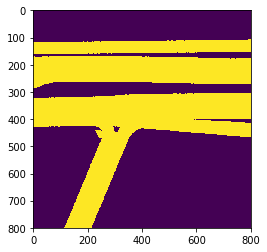

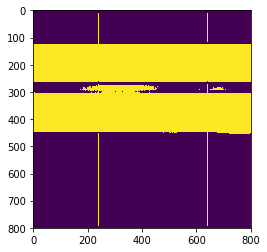


Epoch 2/12
----------
Iteration: 3528/3528 loss: 0.40700721740722656 dice_score: 0.29649639129638677
train Loss: 1.7703 Dice: 0.3525


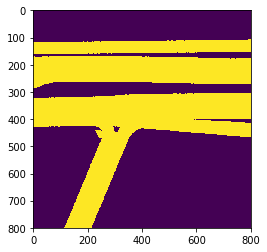

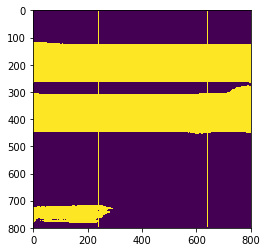


Epoch 3/12
----------
Iteration: 3528/3528 loss: 0.2077924609184265 dice_score: 0.396103769540786747
train Loss: 1.4873 Dice: 0.3761


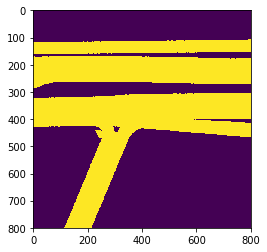

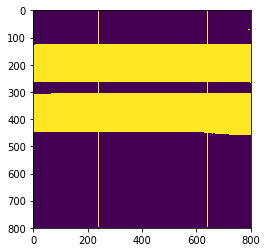


Epoch 4/12
----------
Iteration: 3528/3528 loss: 0.29292136430740356 dice_score: 0.35353931784629824
train Loss: 1.2424 Dice: 0.3965


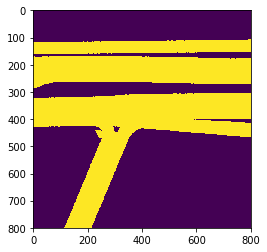

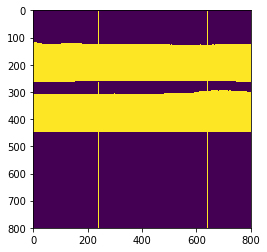


Epoch 5/12
----------
Iteration: 3528/3528 loss: 0.15997380018234253 dice_score: 0.42001309990882874
train Loss: 1.0442 Dice: 0.4130


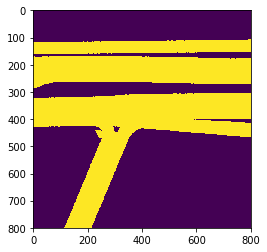

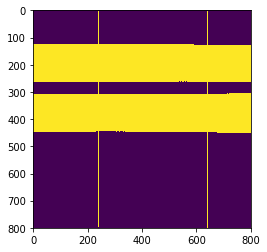


Epoch 6/12
----------
Iteration: 3528/3528 loss: 0.09378600120544434 dice_score: 0.453106999397277836
train Loss: 0.7536 Dice: 0.4372


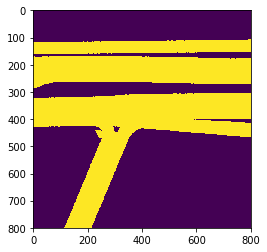

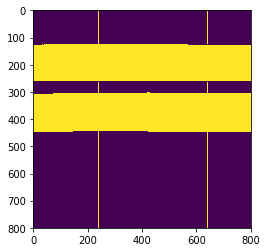


Epoch 8/12
----------
Iteration: 3528/3528 loss: 0.13611268997192383 dice_score: 0.431943655014038133
train Loss: 0.6484 Dice: 0.4460


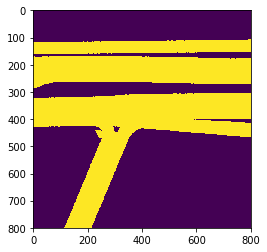

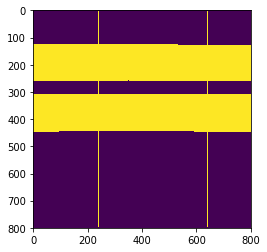


Epoch 9/12
----------
Iteration: 3528/3528 loss: 0.09858375787734985 dice_score: 0.450708121061325145
train Loss: 0.5641 Dice: 0.4530


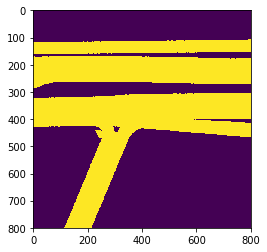

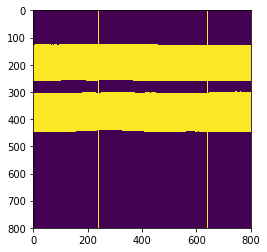


Epoch 10/12
----------
Iteration: 3528/3528 loss: 0.03802770376205444 dice_score: 0.480986148118972834
train Loss: 0.5010 Dice: 0.4582


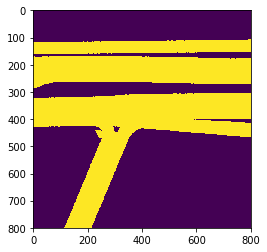

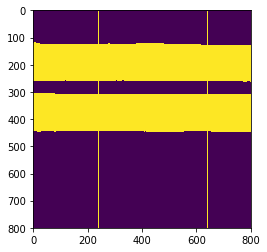


Epoch 11/12
----------
Iteration: 3528/3528 loss: 0.10289692878723145 dice_score: 0.448551535606384317
train Loss: 0.4496 Dice: 0.4625


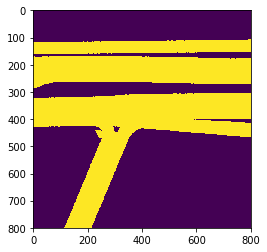

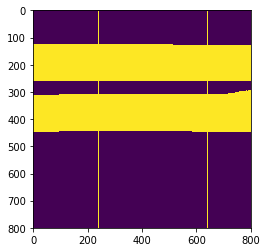


Epoch 12/12
----------
Iteration: 3528/3528 loss: 0.05379641056060791 dice_score: 0.473101794719696044
train Loss: 0.4072 Dice: 0.4661


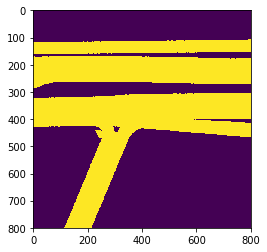

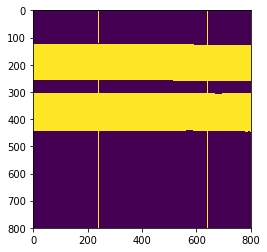


Training time: 88minutes 49.886263608932495s
Best val Dice: 0.000000


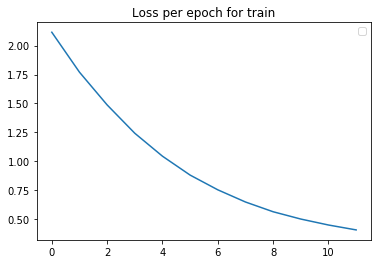

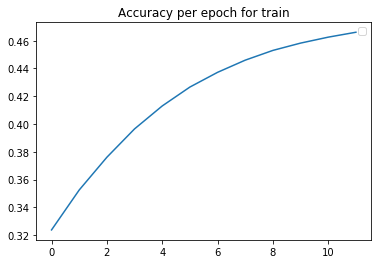

In [549]:
model, best_model_wts = train_model(model, 
                                    trainloader, dice_loss, optimizer, None, 12)

### Sample Predictions

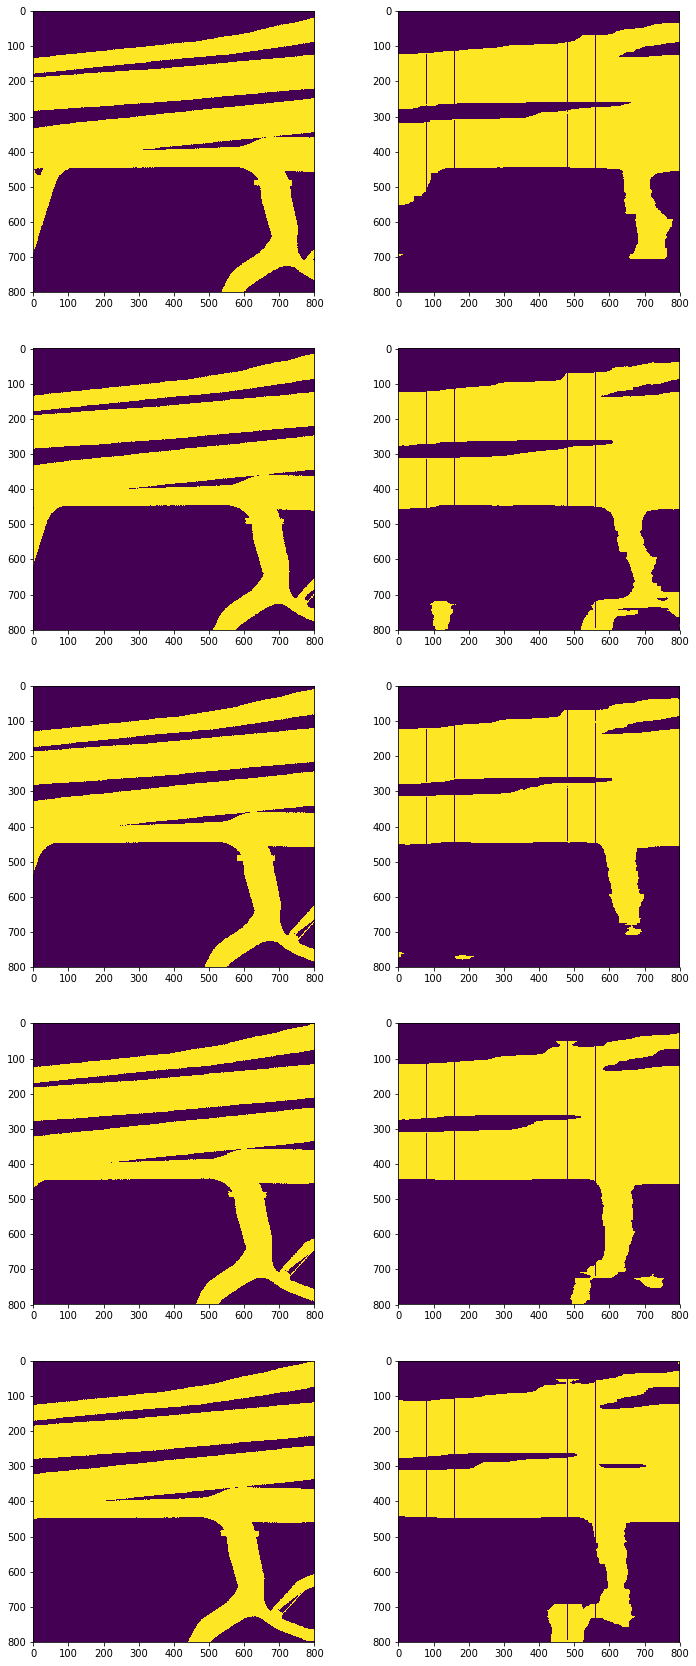

In [581]:
n_samples = 5
start = 1000
threshold = 0.5

fig, ax = plt.subplots(n_samples, 2, figsize = (12, 30))

for i in range(start, start + n_samples):
    ax[i-start, 0].imshow(labeled_trainset[i][2].cpu().numpy())
    
    inp = labeled_trainset[i][0].cuda()
    out = model(inp)
    ax[i-start, 1].imshow((out>threshold).squeeze().cpu().detach().numpy())

In [594]:
torch.save(best_model_wts, '/scratch/bva212/dl_project/binary_road_map_resnet18.pth')